<a href="https://colab.research.google.com/github/bengisudurugoksu/AnomalyDetectioninTimeSeries/blob/main/finance/1d-cnn_finance_testing/1DCNN_Finance_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-523715286.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(ticker, start="2021-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


Raw test head:
 Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2021-01-04  125.974480  130.062977  123.394829  129.975370  143301900
2021-01-05  127.531982  128.242613  125.020474  125.468268   97664900
2021-01-06  123.239059  127.570927  123.024899  124.329329  155088000
2021-01-07  127.444389  128.135547  124.465627  124.952354  109578200
2021-01-08  128.544373  129.108977  126.772682  128.914274  105158200

Flattened test head:
 Price            Close        High         Low        Open     Volume
Date                                                                 
2021-01-04  125.974480  130.062977  123.394829  129.975370  143301900
2021-01-05  127.531982  128.242613  125.020474  125.468268   97664900
2021-01-06  123.239059  127.570927  123.024899  124.329329  155088000
2021-01-07  127.444389  128.135547  124.465627  124

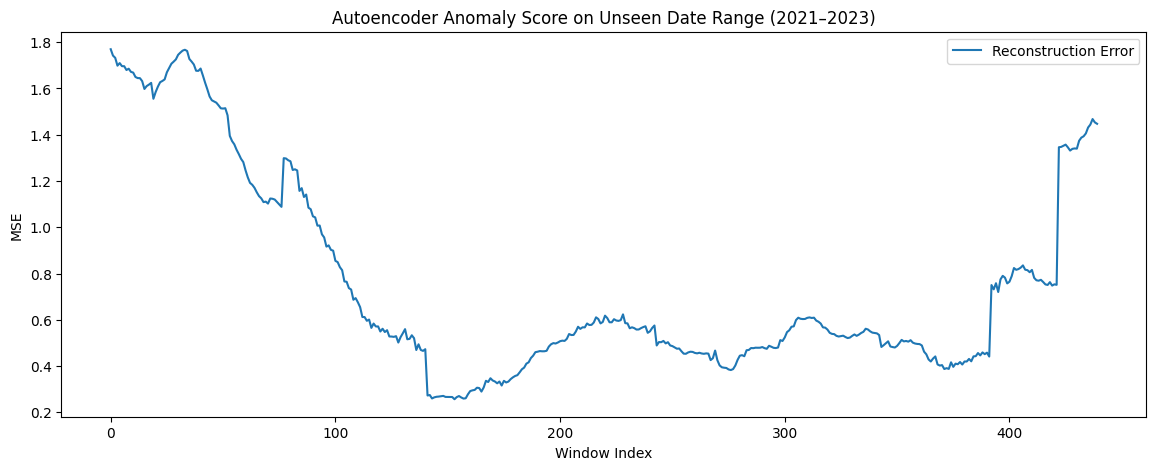

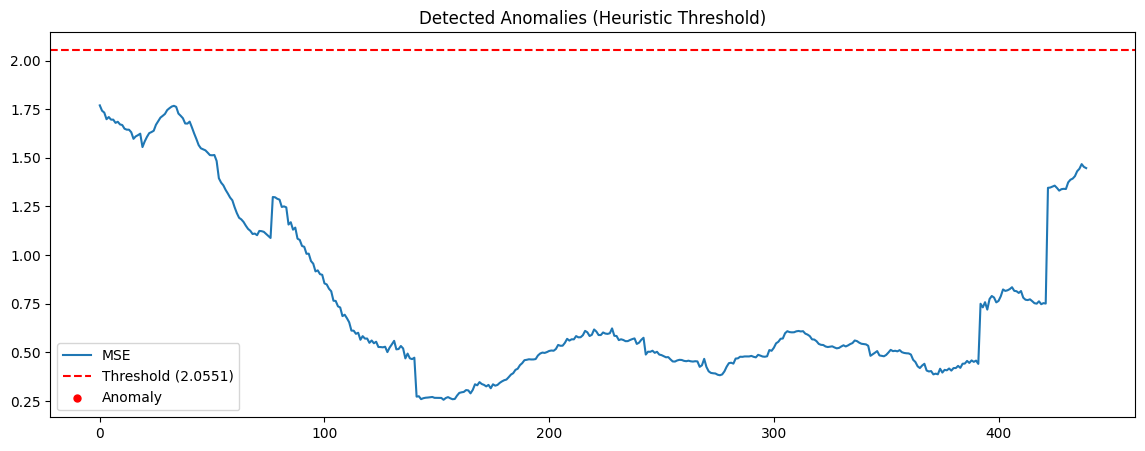

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ============================
# 1) YENİ TARİHTEN VERİYİ ÇEK
# ============================

ticker = "AAPL"

df_test = yf.download(ticker, start="2021-01-01", end="2023-01-01")
print("Raw test head:\n", df_test.head())

# ============================
# 2) MULTIINDEX KOLONLARI FLATTEN ET
# ============================

# Eğer yfinance MultiIndex kolon döndürdüyse:
if isinstance(df_test.columns, pd.MultiIndex):
    df_test.columns = df_test.columns.droplevel(1)

print("\nFlattened test head:\n", df_test.head())

# ============================
# 3) FEATURE SEÇİMİ — FIXED
# ============================

# Adj Close yok -> Close ile aynı değeri ekle
df_test["Adj Close"] = df_test["Close"]

# TRAIN pipeline ile birebir aynı feature order:
features = ["Open", "High", "Low", "Close", "Volume", "Adj Close"]

df_test = df_test[features].dropna()

base_array = df_test.values  # shape: (N, 6)
print("\nBase test array shape:", base_array.shape)


# ============================
# 4) İLK NORMALİZASYON (0. scaler)
# TRAIN pipeline ile birebir aynı mantık:
# Tüm 6 base feature normalize edilir.
# ============================

scaler0 = StandardScaler()
base_scaled = scaler0.fit_transform(base_array)

# ============================
# 5) WINDOW'LAMA
# ============================

def create_windows(data, window_size=64):
    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i:i+window_size])
    return np.array(X)

X_base = create_windows(base_scaled, window_size=64)
print("Windowed base shape:", X_base.shape)

# ============================
# 6) FEATURE ENGINEERING
# (volatility rate, rolling diff, jump ratio)
# TRAIN'deki ile birebir aynı
# ============================

X_new = []

for window in X_base:
    dfw = pd.DataFrame(window, columns=[f"f{i}" for i in range(6)])

    # volatility (std)
    vol = dfw.std(axis=1)
    vol_rate = vol.diff().fillna(0)

    # rolling mean diff
    roll_mean = dfw.mean(axis=1).rolling(5, min_periods=1).mean()
    roll_diff = roll_mean.diff().fillna(0)

    # jump ratio (son - ilk / ilk)
    jump_ratio = (dfw.iloc[:, -1] - dfw.iloc[:, 0]) / (np.abs(dfw.iloc[:, 0]) + 1e-6)

    new_feats = np.vstack([vol_rate, roll_diff, jump_ratio]).T  # shape (64, 3)
    enriched = np.hstack([window, new_feats])  # shape (64, 9)
    X_new.append(enriched)

X_enriched = np.array(X_new)
print("Enriched test shape (64,9):", X_enriched.shape)

# ============================
# 7) İKİNCİ NORMALİZASYON (1. scaler)
# ============================

scaler1 = StandardScaler()
X_test_final = scaler1.fit_transform(
    X_enriched.reshape(-1, 9)
).reshape(X_enriched.shape)

print("\nFinal Test Shape:", X_test_final.shape)

# ============================
# 8) AUTOENCODER'I YÜKLE
# ============================

auto_path = "/content/drive/MyDrive/anomaly_project/models/1dcnn_autoencoder_finance_v6_1.keras"
autoencoder = load_model(auto_path)

# ============================
# 9) INFERENCE (RECONSTRUCTION ERROR)
# ============================

recons = autoencoder.predict(X_test_final)
mse = np.mean(np.square(X_test_final - recons), axis=(1, 2))

print("\nExample MSE values:", mse[:10])

# ============================
# 10) GRAFİK — ANOMALY SCORE
# ============================

plt.figure(figsize=(14,5))
plt.plot(mse, label="Reconstruction Error")
plt.title("Autoencoder Anomaly Score on Unseen Date Range (2021–2023)")
plt.xlabel("Window Index")
plt.ylabel("MSE")
plt.legend()
plt.show()

# OPTIONAL: Basit threshold ile anomaly işaretleme
threshold = np.mean(mse) + 3*np.std(mse)
pred = (mse > threshold).astype(int)

plt.figure(figsize=(14,5))
plt.plot(mse, label="MSE")
plt.axhline(threshold, color="red", linestyle="--", label=f"Threshold ({threshold:.4f})")
plt.scatter(np.where(pred==1), mse[pred==1], color="red", label="Anomaly", s=25)
plt.title("Detected Anomalies (Heuristic Threshold)")
plt.legend()
plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


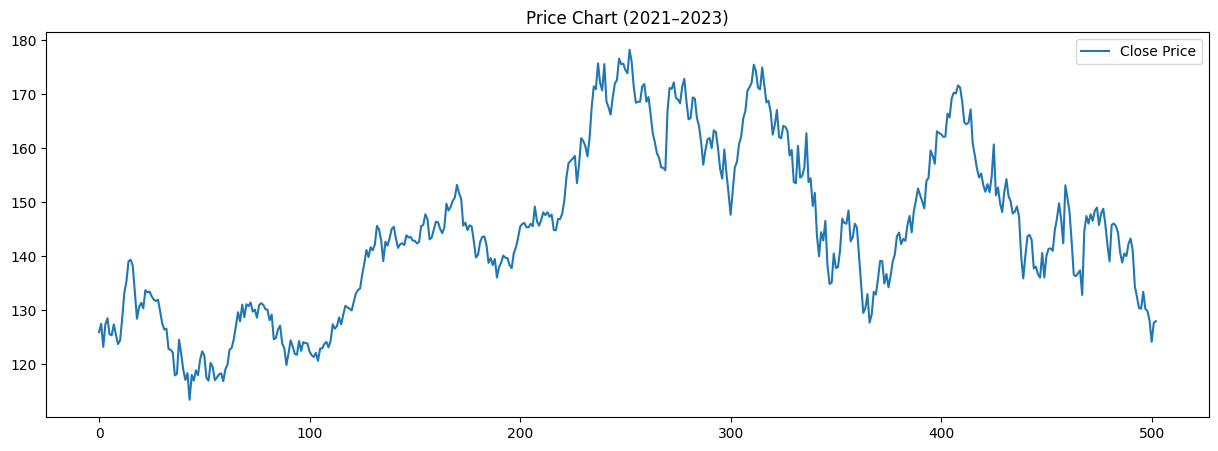

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df_test["Close"].values, label="Close Price")
plt.title("Price Chart (2021–2023)")
plt.legend()
plt.show()


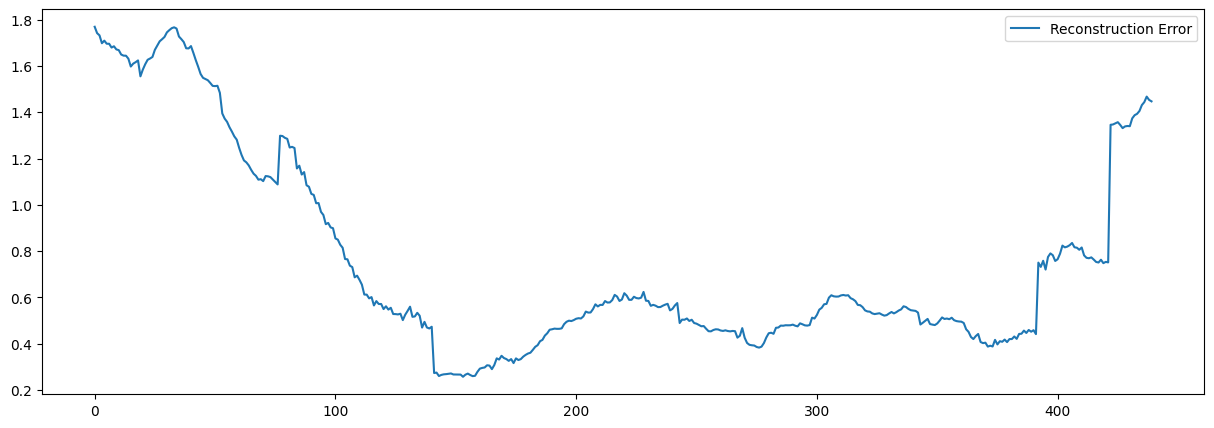

In [7]:
plt.figure(figsize=(15,5))
plt.plot(mse, label="Reconstruction Error")
plt.legend()
plt.show()


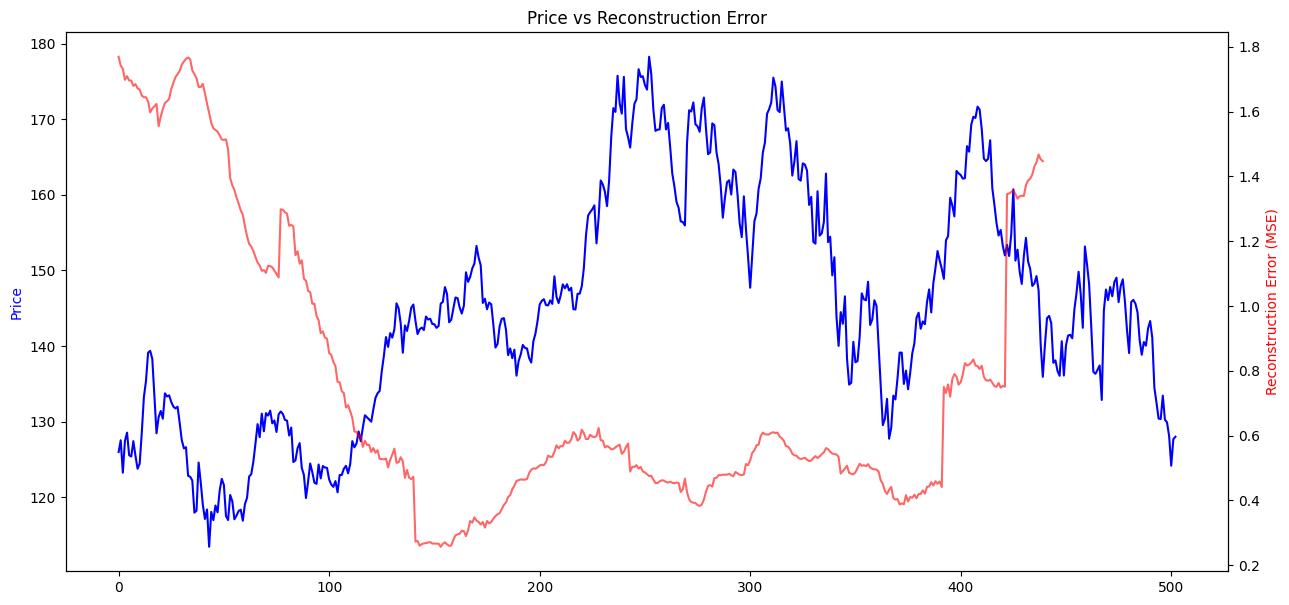

In [8]:
plt.figure(figsize=(15,7))

ax1 = plt.gca()
ax1.plot(df_test["Close"].values, color='blue', label="Close Price")
ax1.set_ylabel("Price", color='blue')

ax2 = ax1.twinx()
ax2.plot(mse, color='red', alpha=0.6, label="Reconstruction Error")
ax2.set_ylabel("Reconstruction Error (MSE)", color='red')

plt.title("Price vs Reconstruction Error")
plt.show()
